# K-Nearest Neighbors using Iris Data

In [7]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data,
                      columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

digits = sklearn_to_df(datasets.load_digits())
digits.head()


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [8]:
def normalize(df):
    '''Feature scaling using mean normalization.
    Scales feature values between -1 and 1.'''

    for column in df.columns[:-1]:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df


normalized_digits = normalize(digits)
normalized_digits.head(2)


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,NaN,-0.334923,-0.043069,0.273995,-0.664293,-0.843894,-0.40961,-0.124988,-0.059061,-0.623836,...,-0.209727,-0.02359,-0.298998,0.086695,0.208235,-0.366669,-1.146328,-0.505529,-0.195953,0
1,NaN,-0.334923,-1.094632,0.038637,0.268676,-0.137981,-0.40961,-0.124988,-0.059061,-0.623836,...,-0.209727,-0.02359,-0.298998,-1.089080,-0.248940,0.849396,0.548408,-0.505529,-0.195953,1


The KNN model does not work well with the digits dataset because all of its features are pixel brightnesses and the euclidean distances for bright pixels doesn't give us much information for distingusihing between digits.

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Python39\lib\site-packages\matplotlib\colors.py:1019: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


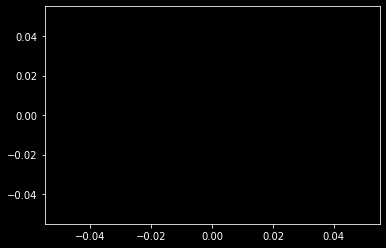

((1797, 64), (1797,))

In [9]:
X = normalized_digits.drop(columns='target')
y = normalized_digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
plt.figure()
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, cmap=cmap, edgecolor='k', s=20)
plt.show()
X.shape, y.shape


In [10]:
class Distance:
    
    def hamming(self, x1, x2):
        ''' Counts the number of attributes where x1 and x2 differ '''

        return np.sum(x1 != x2) / len(x1)

    def manhattan(self, x1, x2):
        '''
        Also known as cityblock distance or L1 distance
        '''
        return np.sum(np.abs(x1 - x2))

    def euclidean(self, x1, x2):
        ''' 
        Also known as L2 distance. 

        Symmetrical, spherical, treats all dimensions equally
        Sensitive to extreme differences in a single attribute '''
        return np.sqrt((np.sum((x1 - x2) ** 2)))

    def minkowski(self, x1, x2, p):
        '''
        Also known as p-norm distance

        approximate hamming distance (logical AND): p=0
        manhattan distance: p=1
        euclidean distance: p=2 
        logical OR: p=inf
        '''
        return (np.sum(np.abs(x1 - x2) ** p)) ** (1 / p)

    def chebyshev(x1, x2):
        return np.max(np.abs(x1 - x2))


In [11]:
from collections import Counter

class KNN:

    def __init__(self, distance_fn, k=3):
        self.k = k
        self.distance_fn = distance_fn
         
    def fit(self, X, y):
        self.X_train = X.to_numpy()
        self.y_train = y.to_numpy()

    def predict(self, X):
        X = X.to_numpy()
        predicted_labels = []
        for x in X:
            distances = [self.distance_fn(x, x_train) for x_train in self.X_train] # calculate distance for all data points
            k_indices = np.argsort(distances)[:self.k] # desc sort the distances and take the top k shortest distances
            k_nearest_labels = [self.y_train[i] for i in k_indices] # create a list of the labels coressponding to those indices
            classification = Counter(k_nearest_labels).most_common(1)[0][0] # Use the most common neighbor class as the classifcation
            predicted_labels.append(classification)
        return np.array(predicted_labels)


In [12]:

def test():
    k = 3
    distance = Distance()
    knn = KNN(distance.euclidean, k)
    knn.fit(X_train, y_train)

    a = np.array((1, 1, 11))
    b = np.array((1, 1, 0))
    c = np.array((1, 1, -1))
    assert(distance.euclidean(a, b) == 11)
    assert(distance.euclidean(c, b) == 1)
    assert(distance.euclidean(b, c) == 1)
    assert(distance.manhattan(a, b) == 11)

    predict = knn.predict(X_test)
    accuracy = np.sum(predict == y_test) / len(y_test)
    return accuracy

test()


0.09166666666666666